In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
train_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training'
test_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test'

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to match training dimensions
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with same mean/std as training
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
# Load the test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
train_dataset.classes

['Apple 6',
 'Apple Braeburn 1',
 'Apple Crimson Snow 1',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith 1',
 'Apple Pink Lady 1',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious 1',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apple hit 1',
 'Apricot 1',
 'Avocado 1',
 'Avocado ripe 1',
 'Banana 1',
 'Banana Lady Finger 1',
 'Banana Red 1',
 'Beetroot 1',
 'Blueberry 1',
 'Cabbage white 1',
 'Cactus fruit 1',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula 1',
 'Carrot 1',
 'Cauliflower 1',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier 1',
 'Cherry Wax Black 1',
 'Cherry Wax Red 1',
 'Cherry Wax Yellow 1',
 'Chestnut 1',
 'Clementine 1',
 'Cocos 1',
 'Corn 1',
 'Corn Husk 1',
 'Cucumber 1',
 'Cucumber 3',
 'Cucumber Ripe 1',
 'Cucumber Ripe 2',
 'Dates 1',
 'Eggplant 1',
 'Eggplant long 1',
 'Fig 1',
 'Ginger Root 1',
 'Granadilla 1',
 'Grape Blue 1',
 'Grape Pink 1',
 'Grape White 1',
 'Grape White 2',
 'Grape White 3',
 'Grape White

In [5]:
import random
from PIL import Image

def show_example_images(data_path, title, num_images=10, image_size=(100, 100)):
  class_names = os.listdir(data_path)
  fig, axes = plt.subplots(2, 5, figsize=(15,6))

  for i, ax in enumerate(axes.ravel()):  # Flaches Iterieren über die Achsen
        if i >= num_images:
            break

        random_class = random.choice(class_names)
        class_path = os.path.join(data_path, random_class)
        random_image = random.choice(os.listdir(class_path))

        img_path = os.path.join(class_path, random_image)
        img = Image.open(img_path)

        if img.size != image_size:
          img = img.resize(image_size)

        ax.imshow(img)
        ax.set_title(random_class)
        ax.axis('off')

  plt.suptitle(title, fontsize=16)
  plt.show()

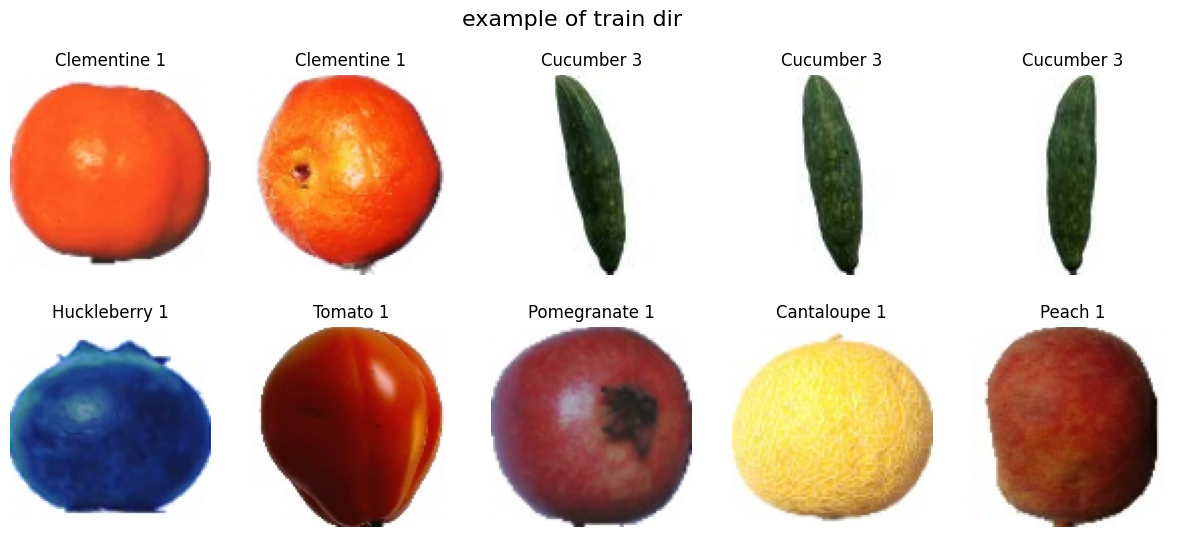

In [6]:
show_example_images(train_dir,'example of train dir')

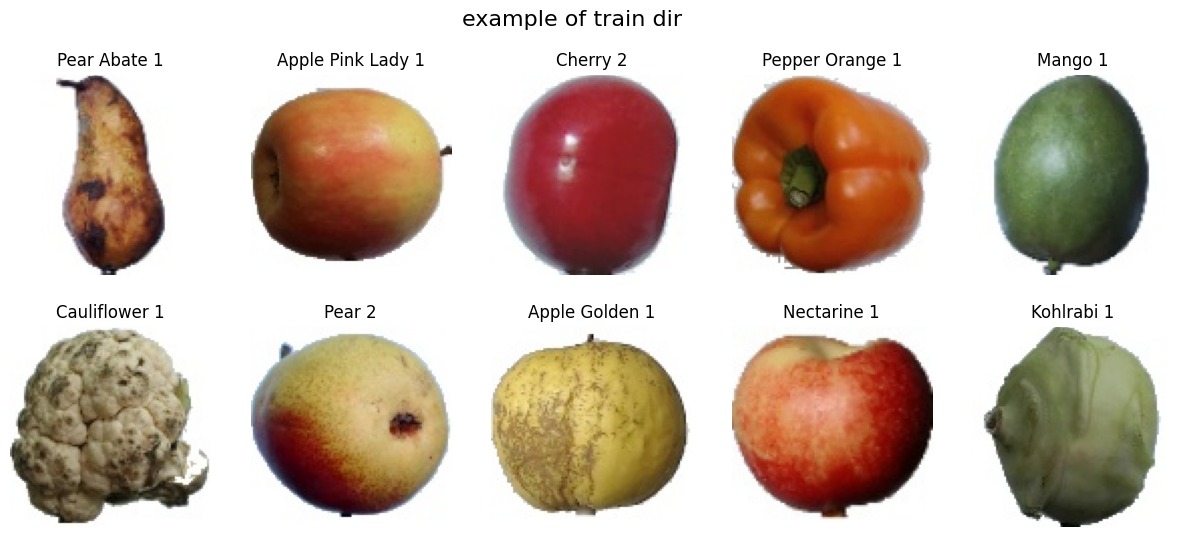

In [7]:
show_example_images(test_dir,'example of train dir')

In [8]:

# Define model
class FruitNet(nn.Module):
    def __init__(self, num_classes):
        super(FruitNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = FruitNet(num_classes=len(train_dataset.classes))
model = model.to(device)

In [14]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
train_loss_history, train_acc_history = [], []

In [16]:
# Training and validation loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_acc_history.append(train_accuracy)
    train_loss_history.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.7855, Train Accuracy: 77.24%
Epoch [2/10], Train Loss: 0.1924, Train Accuracy: 93.76%
Epoch [3/10], Train Loss: 0.1330, Train Accuracy: 95.78%
Epoch [4/10], Train Loss: 0.1097, Train Accuracy: 96.61%
Epoch [5/10], Train Loss: 0.0932, Train Accuracy: 97.16%
Epoch [6/10], Train Loss: 0.0820, Train Accuracy: 97.58%
Epoch [7/10], Train Loss: 0.0752, Train Accuracy: 97.95%
Epoch [8/10], Train Loss: 0.0724, Train Accuracy: 97.98%
Epoch [9/10], Train Loss: 0.0625, Train Accuracy: 98.31%
Epoch [10/10], Train Loss: 0.0616, Train Accuracy: 98.38%


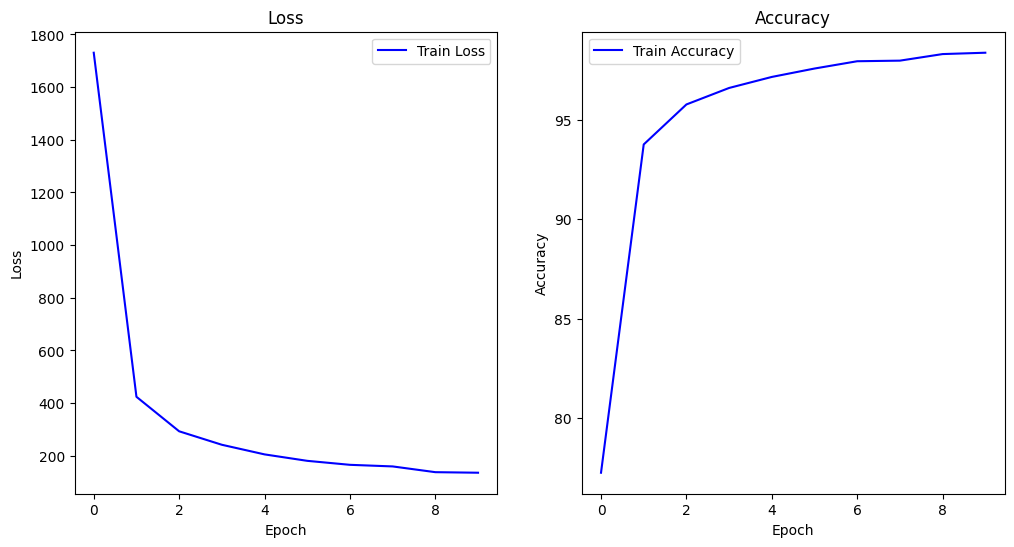

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss", color="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy", color="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [20]:
# Evaluate on the test dataset
model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.92%


In [21]:
# Path to save the model
model_save_path = 'fruit361_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to fruit361_model.pth
